## Imports and global settings

In [336]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Dense
from keras.layers import Lambda, Dropout, Flatten
from keras.optimizers import Adam, Nadam, Adamax, Adadelta, Adagrad, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint

import utils
reload(utils)
from utils import plots, remove_chars_re, plot_files

from IPython.display import FileLink
from IPython.core.debugger import Tracer

%matplotlib inline

In [4]:
path = './'
batch_size = 64
image_size = (224, 224)

## Load the data

#### Create a keras data generator, that flows the images from the specified dir.

In [356]:
def get_batch(path, batch_size, shuffle=True, augument=False, class_mode='categorical'):
    if augument:
        data_generator = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            shear_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        data_generator = ImageDataGenerator()
    return data_generator.flow_from_directory(directory=path,
                                              batch_size=batch_size,
                                              target_size=image_size,
                                              shuffle=shuffle,
                                              class_mode=class_mode)

#### Load all sets.

In [357]:
train = get_batch(os.path.join(path, 'train/'),
                  augument=True, batch_size=batch_size)
valid = get_batch(os.path.join(path, 'valid/'), batch_size=batch_size * 2)
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## Define the model.

Define a convolutional layer

In [7]:
def convolution(model, layers, filters):
    for layer_index in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    return model

Preprocessing the image: Sub imagenet mean values; Flip channels from RGB to BGR.

In [8]:
def preprocess(image):
    # input is shaped (batch_size, channels, width, height)
    imagenet_means = np.asarray([123.68, 116.779, 103.939]).reshape([3, 1, 1])
    image -= imagenet_means
    # Flip the channels
    return image[:, ::-1, :, :]

Define the model, according to the VGG paper.

In [9]:
def vgg16_model():
    model = Sequential()
    model.add(Lambda(preprocess, input_shape=(3, 224, 224)))
    model = convolution(model, 2, 64)
    model = convolution(model, 2, 128)
    model = convolution(model, 3, 256)
    model = convolution(model, 3, 512)
    model = convolution(model, 3, 512)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    return model

model = vgg16_model()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Load the precomputed Imagenet weights.

In [10]:
def vgg_load_weights(model):
    # Get file uses downloaded weights, or downloads them if not present.
    path = 'http://www.platform.ai/models/'
    weights_file = 'vgg16.h5'
    weights = get_file(weights_file, path + weights_file,
                       cache_subdir='models')
    model.load_weights(weights)
    return model

model = vgg_load_weights(model)

Finally, compile and the model is ready to use.

In [40]:
def vgg_compile(model, optimizer=None, learning_rate=None):
    if not optimizer:
        optimizer = Adam()
    if learning_rate:
        optimizer.lr.set_value(0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = vgg_compile(model)

Decode the ids of the 1000 classes in the Imagenet competition for humans.

In [12]:
def setup_imagenet_id_to_class():
    path = 'http://www.platform.ai/models/'
    class_mappings_filename = 'imagenet_class_index.json'
    mappings_file = get_file(class_mappings_filename, path +
                             class_mappings_filename, cache_subdir='models')
    with open(mappings_file, 'r') as f:
        mappings = json.load(f)

    return mappings
# Read the mappings from class id to class name
mappings = setup_imagenet_id_to_class()


def imagenet_id_to_class(id):
    '''A convenience function to extract the class name
    '''
    return mappings[str(id)][1]

Predict some images

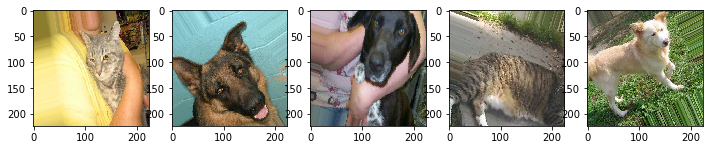

In [19]:
batch = train.next()
images = batch[0][0:5]
predictions = model.predict(images)
predictions_class_ids = np.argmax(predictions, axis=1)
predicted_classes = [imagenet_id_to_class(id) for id in predictions_class_ids]
plots(images), titles = predicted_classes)

## Finetune the model

Pop the 1000 classes last layer off our model, and replace it with a 2 class (dog, cat).

In [21]:
def vgg_finetune(model):
    # Freeze the original model
    for layer in model.layers:
        layer.trainable = False
    # Replace the last layer
    model.pop()
    model.add(Dense(2, activation='softmax'))
    model = vgg_compile(model)
    return model

model = vgg_finetune(model)

In [364]:
# model.optimizer.lr.set_value(0.001)
model = vgg_compile(model, optimizer=RMSprop()) # Adadelta

In [365]:
now = datetime.datetime.now()
date_string = "{0}.{1}-{2}.{3}.{4}".format(
    now.day, now.month, now.hour, now.minute, now.second)
filepath = 'checkpoint-' + date_string + '-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)

model.fit_generator(train, samples_per_epoch=train.nb_sample,
                    nb_epoch=1,
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

Epoch 1/1
 6464/23000 [=======>......................] - ETA: 439s - loss: 0.2446 - acc: 0.9539

KeyboardInterrupt: 

## Finetuning with Embeddings 

In [363]:
# TODO

## Review Results

In [203]:
# Get validation predictions
valid = get_batch(os.path.join(path, 'valid/'),
                  batch_size=batch_size * 2,
                  shuffle=False,
                  class_mode=None)
val_results = model.predict_generator(valid, valid.nb_sample)

Found 2000 images belonging to 2 classes.


In [269]:
# cat_prob = val_results[:,0]
probabilities = val_results[:, 1]
filenames = np.array([os.path.join(path, 'valid', filename)
                      for filename in valid.filenames])

classes = valid.classes
results = np.stack([probabilities,
                    filenames,
                    classes])
# How many images can we display at once
max_images = 4

#### Correct labels at random

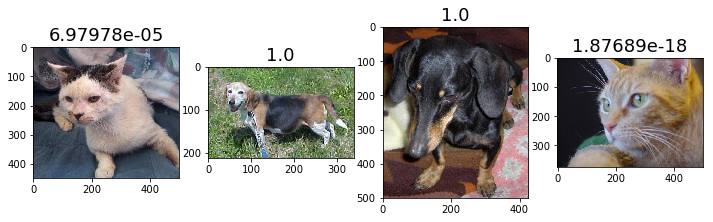

In [270]:
corrects = np.where(np.round(probabilities) == classes)[0]
random_correct_indexes = np.random.permutation(corrects)[0:max_images]
plot_files(filenames[random_correct_indexes],
           titles=probabilities[random_correct_indexes])

#### Incorrect labels at random

40


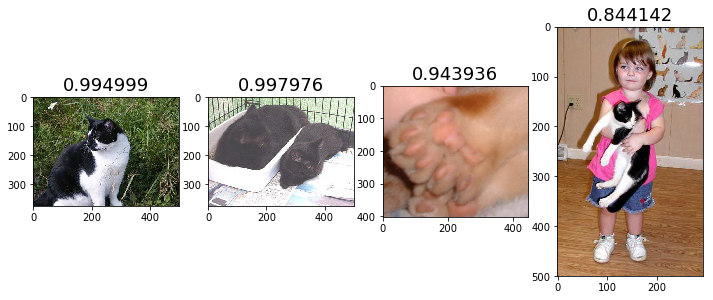

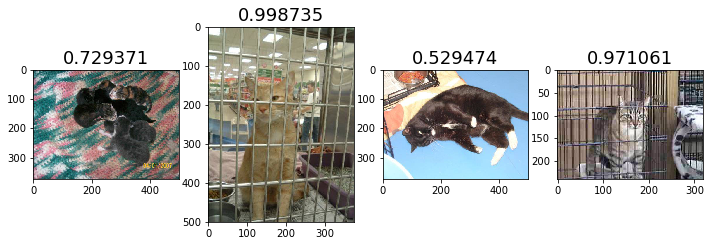

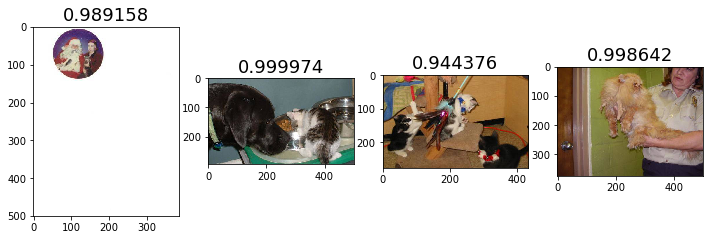

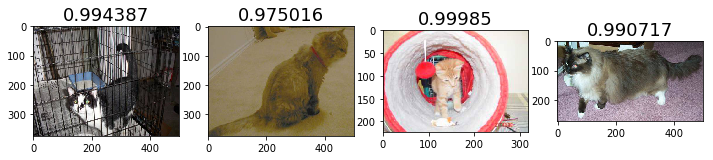

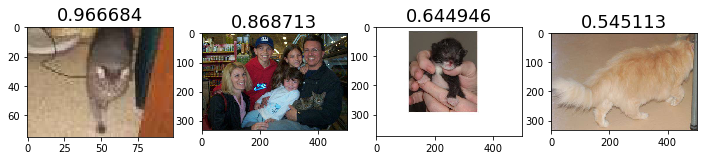

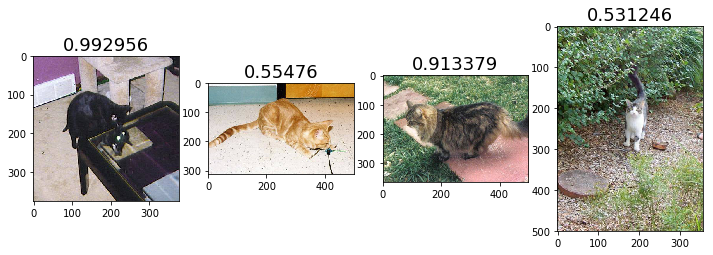

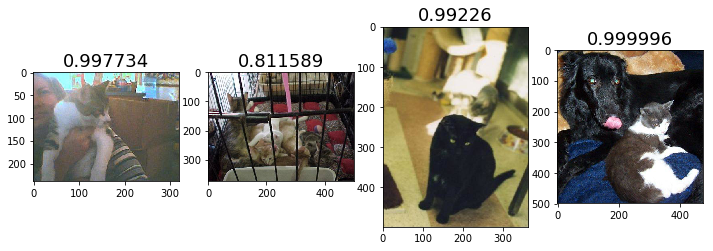

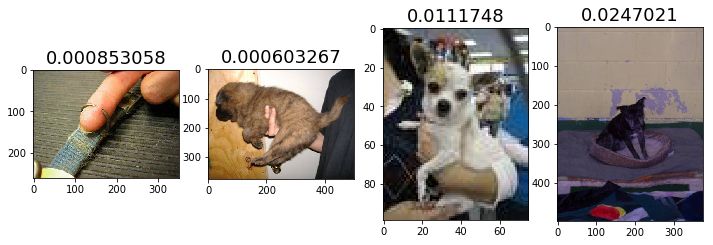

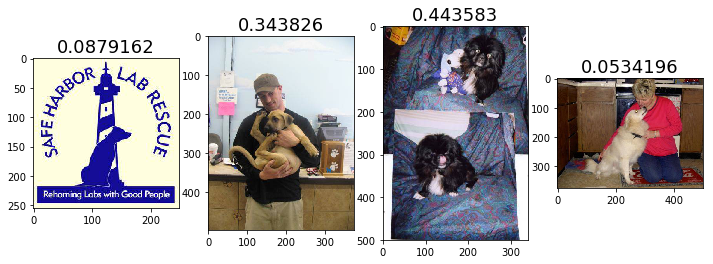

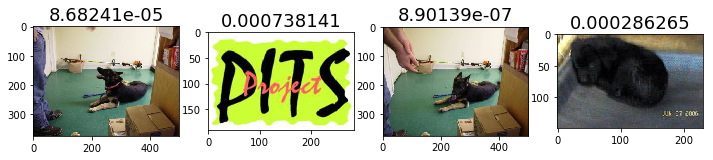

In [338]:
# Since they are a small amount we will display them all
incorrects = np.where(np.round(probabilities) != classes)[0]
# random_incorrect_indexes = np.random.permutation(incorrects)[0:max_images]
# display all image in the incorrect index, max_images at a time
plot_files(filenames[incorrects],
           titles=probabilities[incorrects],
           images_per_row=max_images)


#### The most correct labels of each class (high prob, but correct)


#### The most incorrect labels of each class (high prob, but incorrect)


##### Incorrect dogs

In [322]:
# Get indexes where both class is dog and we were off
incorrect_dogs = np.where(
    (classes == 1) & (np.round(probabilities) != classes))[0]
# Returns the indexes that would sort the array
sort_indexes = np.argsort(probabilities[incorrect_dogs])
# Apply the sort indexes to the incorrect dogs indexes
sorted_incorrect_dogs = incorrect_dogs[sort_indexes]
# Select only the first max_images incorrect dogs
sorted_incorrect_dogs = sorted_incorrect_dogs[:max_images]

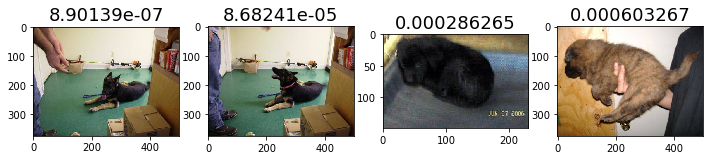

In [323]:
plot_files(filenames[sorted_incorrect_dogs],
           titles=probabilities[sorted_incorrect_dogs])

##### Incorrect cats

In [342]:
# Get indexes where both class is cat and we were off
incorrect_cats = np.where(
    (classes == 0) & (np.round(probabilities) != classes))[0]
# Get the indexes that would sort the probabilities array
sort_indexes = np.argsort(probabilities[incorrect_cats])
# Reverse sort indexes, because we want low probabilities, not high
sort_indexes = sort_indexes[::-1]
# Use the sort indexes to sort the incorrect cat indexes
incorrect_cats_sorted = incorrect_cats[sort_indexes]
# Use only the first max_images incorrect cats
incorrect_cats_sorted = incorrect_cats_sorted[:max_images]

4


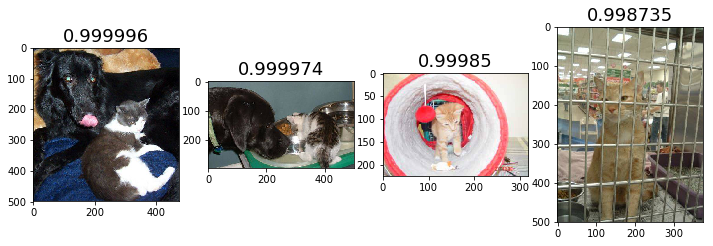

In [343]:
plot_files(filenames[incorrect_cats_sorted],
           titles=probabilities[incorrect_cats_sorted],
           images_per_row=max_images)

#### The most uncertian labels (probability close to 0.5)

In [352]:
# Get distance to 0.5 (most uncertain)
most_uncertain = np.abs(probabilities - 0.5)
# Sort by distance to 0.5 (most uncertain)
sort_indexes = np.argsort(most_uncertain)
# Get only the first max_images
sort_indexes = sort_indexes[:max_images]

4


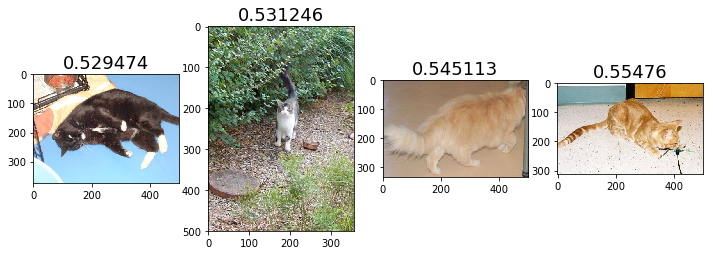

In [353]:
plot_files(filenames[sort_indexes],
           titles=probabilities[sort_indexes],
           images_per_row=max_images)


## Submit results

#### Prepare predictions for test set


In [62]:
test_predictions = model.predict_generator(test, val_samples=test.nb_sample)

In [87]:
# get path to test files
test_filepaths = test.filenames


def filter_test_filepath(filepath):
    '''Utility func to transform 'test/1032.jpg' to 1032
    '''
    filepath = remove_chars_re(filepath, 'test/')
    return int(remove_chars_re(filepath, '.jpg'))
# Format test files as ids
test_ids = [filter_test_filepath(filepath)
            for filepath in test_filepaths]

In [93]:
# Get dog predictions only
dog_predictions = test_predictions[:, 1]

In [94]:
# Trim the predictions, so that we are not penalized for confident mistakes
predictions_trim = np.clip(dog_predictions, 0.05, 0.95)

In [96]:
predictions = np.stack([test_ids, predictions_trim], axis=1)

In [105]:
predictions[1:10, 1]

array([ 0.95,  0.05,  0.05,  0.05,  0.95,  0.05,  0.05,  0.05,  0.95])

#### Sanity check the results


In [116]:
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)
test_batch = test.next()
start = 0

In [112]:
test_batch.shape

(64, 3, 224, 224)

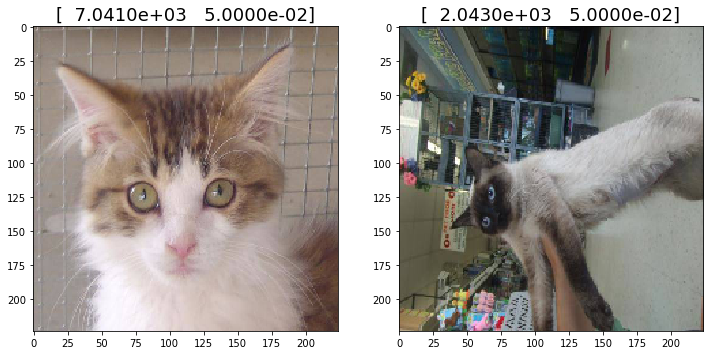

In [126]:
start = start + 2
end = start + 2
plots(test_batch[start:end], titles=predictions[start:end])

#### Export the predictions to csv with Pandas.

In [139]:
import pandas as pd
now = datetime.datetime.now()
date_string = "{0}.{1}-{2}.{3}.{4}".format(
    now.day, now.month, now.hour, now.minute, now.second)
filename = ("cats_dogs-{0}.csv".format(date_string))
header = ['id', 'label']
df = pd.DataFrame(predictions)
# Convert ids (first column) to int
df[0] = df[0].astype(int)
df.to_csv(filename, header=header, index=False)
FileLink(filename)

#### Submit to kaggle

In [140]:
%
!kg submit - c 'dogs-vs-cats-redux-kernels-edition' - m "$date_string" $filename